In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('master_housing.csv')

In [6]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [8]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [37]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')][['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']]

In [38]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [39]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [40]:
df.population.median()

1195.0

In [216]:
n = len(df)

idx = np.arange(n)

idm = idx.copy()

In [217]:
np.random.seed(42)
np.random.shuffle(idm)

In [218]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [219]:
n,n_val + n_test + n_train

(15687, 15687)

In [220]:
df_train = df.iloc[idm[:n_train]]
df_val = df.iloc[idm[n_train:n_train+n_val]]
df_test = df.iloc[idm[n_train+n_val:]]

In [221]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [222]:
y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)



In [223]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [224]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [225]:
def prepare_X_mean(df):
    df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())
    X = df.values
    return X

In [226]:
def prepare_X_zero(df):
    df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
    X = df.values
    return X

In [227]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [228]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [229]:
X_train_mean = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train_mean, y_train)

X_train_zero = prepare_X_zero(df_train)
z0, z = train_linear_regression(X_train_zero, y_train)

In [230]:
X_val = prepare_X_zero(df_val)

y_pred_mean = w0 + X_val.dot(w)

y_pred_zero = z0 + X_val.dot(z)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

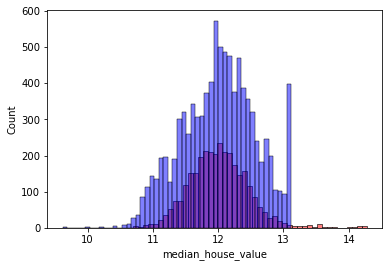

In [231]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

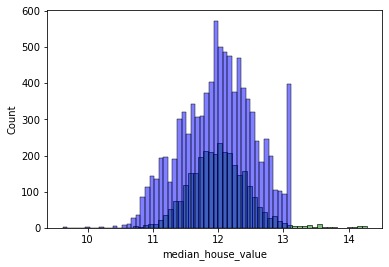

In [232]:
sns.histplot(y_pred_zero, color='green', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)


In [233]:
round(rmse(y_val, y_pred_mean),2)

0.34

In [234]:
round(rmse(y_val, y_pred_zero),2)

0.34

In [235]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [236]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    q0, q = train_linear_regression_reg(X_train_zero, y_train, r=r)
    
    y_pred = q0 + X_val.dot(q)
    score = rmse(y_val, y_pred)
    print('%5s, %.2f, %.2f' % (r, q0, score))
#     print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[1], w[2]))

    0, -9.89, 0.34
1e-06, -9.89, 0.34
0.0001, -9.88, 0.34
0.001, -9.87, 0.34
 0.01, -9.68, 0.34
  0.1, -8.15, 0.34
    1, -3.16, 0.35
    5, -0.85, 0.35
   10, -0.44, 0.35


In [209]:
rmse_values =[]

for x in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    n = len(df)
    idx = np.arange(n)
    idm = idx.copy()
    np.random.seed(x)
    np.random.shuffle(idm)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    df_train = df.iloc[idm[:n_train]]
    df_val = df.iloc[idm[n_train:n_train+n_val]]
    df_test = df.iloc[idm[n_train+n_val:]]
    y_train = np.log1p(df_train.median_house_value)
    y_val = np.log1p(df_val.median_house_value)
    y_test = np.log1p(df_test.median_house_value)
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    X_train_zero = prepare_X_zero(df_train)
    p0, p = train_linear_regression(X_train_zero, y_train)
    X_val = prepare_X_zero(df_val)
    y_pred_zero = p0 + X_val.dot(p)
    a = rmse(y_val, y_pred_zero)
    rmse_values.append(a)
print(rmse_values)

np.std(rmse_values)

C:\Users\Ebenezer\AppData\Local\Temp\ipykernel_22208\1388613331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())


[0.3375948719864775, 0.3380222266644281, 0.33797304111761645, 0.33154213168547547, 0.3396537988963954, 0.34291241722135285, 0.33807049350543383, 0.34612642296176444, 0.3505738548413974, 0.33332009591366635]


0.005383799599389866

In [213]:
n = len(df)
idx = np.arange(n)
idm = idx.copy()
np.random.seed(9)
np.random.shuffle(idm)
n_test = int(n * 0.2)
n_tra_va = n - n_test
df_tra_va = df.iloc[idm[:n_tra_va]]
df_test = df.iloc[idm[n_tra_va:]]
y_tra_va = np.log1p(df_tra_va.median_house_value)
y_test = np.log1p(df_test.median_house_value)
del df_tra_va['median_house_value']
del df_test['median_house_value']
X_train_zero = prepare_X_zero(df_tra_va)
b0, b = train_linear_regression_reg(X_train_zero, y_tra_va, r=0.001)
y_pred = b0 + X_val.dot(b)
score = rmse(y_val, y_pred)
score

C:\Users\Ebenezer\AppData\Local\Temp\ipykernel_22208\1388613331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())


0.33299024416896555